In [1]:
import numpy as np
from pyicecube10.analysis import AnalyzeCircle, energybins
from matplotlib import pyplot as plt
from gammapy.stats import wstat
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
def powerlaw(A, gamma):
    return A * 1e-17 * 1e-3 * (energybins['Enu'] / 1e5)**(-gamma)

In [3]:
def e2ulim(ra, dec,r, b, reshuffle):
    anal = AnalyzeCircle(ra, dec, r, b, unblind=False, reshuffle=reshuffle)

    tpb = anal.total_per_bin()
    bpb = anal.background_per_bin()
    alpha_back = anal.alpha_back

    def log_like(norm, gamma):
        return - 0.5 * sum(wstat(tpb, bpb / alpha_back, alpha_back, anal.expected_counts(powerlaw, norm, gamma)))

    level = 0.9

    #gammas = np.linspace(0, 4.5, 100)
    norms = np.linspace(-10, 30, 400)

    gammas = [2.]  
    ulims = []
    for gamma in gammas:
        like = []
        for norm in norms:
            like.append(log_like(norm, gamma))
        like = np.e ** np.array(like)
        lkl_fl = sorted(like, reverse = True)
        cum_lkl = np.cumsum(lkl_fl) / np.sum(lkl_fl)
        #f = interp1d(cum_lkl, lkl_fl)
        #val = float(f(level))
        ind = np.searchsorted(cum_lkl, level)
        val = lkl_fl[ind]
        ind_ul = np.where(like>=val)[0][-1]
        ulims.append(norms[ind_ul])
    anal._clear_caches()    
    return ulims[0]#, norms, like

In [4]:
ra = 300
decs = [-4, 1, 12, 23, 33, 53, 63]
radii = np.linspace(0.3, 2.7, 25)
betas = np.linspace(0.5, 2.3, 10)

In [5]:
def realisation(dummy):
    results = []
    reshuffle = True
    for dec in decs:
        results.append([])
        for b in betas:
            results[-1].append([])
            for r in radii:
                results[-1][-1].append(e2ulim(ra, dec, r, b, reshuffle)) 
                reshuffle = False 

    return results

In [6]:
from multiprocessing import Pool
from tqdm import tqdm

In [10]:
all_limits = []
with Pool(3) as p:
    num_realis = 9
    for _ in tqdm(p.imap_unordered(realisation, range(num_realis)), total=num_realis):
        all_limits.append(_)
all_limits = np.array(all_limits)        

100%|██████████| 9/9 [51:31:18<00:00, 20608.69s/it]    


In [11]:
np.save('all_limits_0.npy', all_limits)

In [7]:
all_limits = np.load('all_limits_0.npy')

In [21]:
limits = np.median(all_limits, 0)

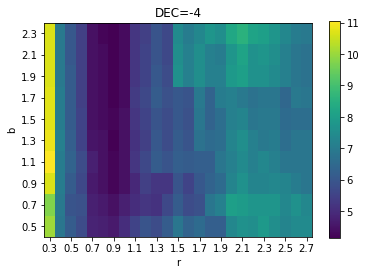

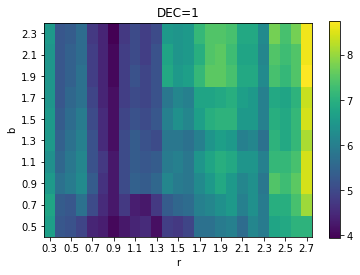

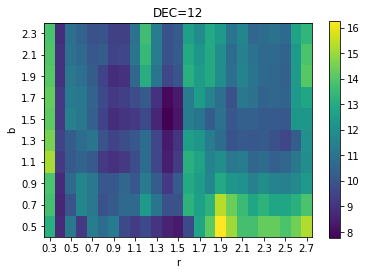

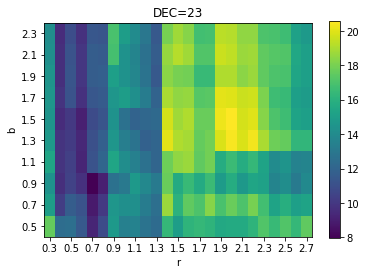

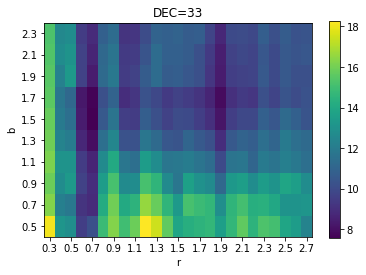

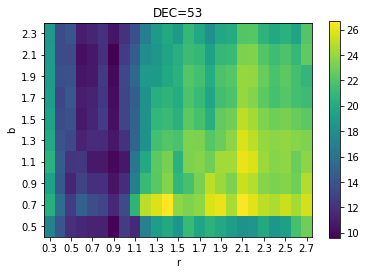

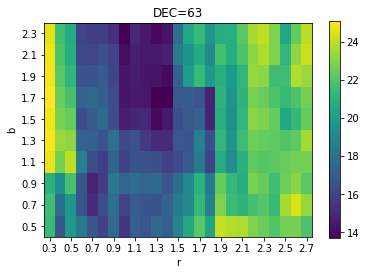

In [22]:
radii_binsize = radii[1] - radii[0]
betas_binsize = betas[1] - betas[0]
for i, dec in enumerate(decs):
    plt.figure()
    plt.imshow(limits[i].astype('float'), 
               origin = 'lower', 
               extent = (0.3-radii_binsize/2, 2.7+radii_binsize/2, 0.5-betas_binsize/2,  2.3+betas_binsize/2)) 
    plt.xticks(radii[::2])
    plt.yticks(betas)
    plt.xlabel('r')
    plt.ylabel('b')
    plt.colorbar()
    plt.title(f'DEC={dec}')

In [23]:
mins = []
for i, dec in enumerate(decs):
    mins.append(limits[i].min())
    min_ind = np.unravel_index(limits[i].argmin(), shape=limits[i].shape)
    print(betas[min_ind[0]], radii[min_ind[1]])

1.2999999999999998 0.9000000000000001
2.3 0.9000000000000001
1.5 1.4000000000000004
0.8999999999999999 0.7000000000000001
1.5 0.7000000000000001
2.0999999999999996 0.9000000000000001
1.7 1.3000000000000003


In [24]:
sens = np.loadtxt('sensitivityE2.csv', delimiter=',')
five_sig = np.loadtxt('five_sig_E2.csv', delimiter=',')

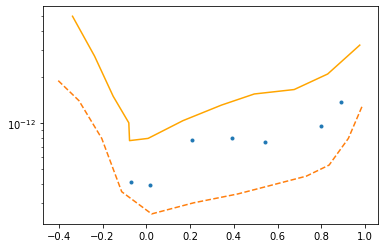

In [25]:
plt.plot(np.sin(np.deg2rad(decs)), np.array(mins) * 1e-13, '.')
plt.plot(sens[:,0], sens[:,1], '--')
plt.plot(five_sig[:,0], five_sig[:,1], c='orange')
plt.yscale('log')